# Filtering Music

In this notebook we will design and use filters to extract specific audio information from a piece of music.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython
import scipy.signal as sp
from scipy.io import wavfile

Let's load a short audio clip (hoping we won't be sued for copyright infringment...)

In [1]:
SF, s = wavfile.read('sm.wav')
IPython.display.Audio(s, rate=SF)

NameError: name 'wavfile' is not defined

Suppose I'm interested in the bass part; I know the bass will have most of its energy in the low frequency range. I could try to filter the audio with a lowpass with cutoff, say, 200Hz and see what comes out of it (you will need headphones to hear properly).

Remember that the clock of the system is given by the sampling rate of the audio clip, so we will need to normalize the frequencies by $SF/2$ so that the highest frequency corresponds to 1. 

Let's start with a Butterworth filter:

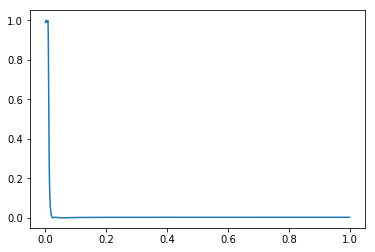

In [3]:
# cutoff frequency in Hz
fc = 200.0
# normalized cutoff freq
wc = fc / (SF/2)

# syntax:
#  scipy.signal.ellip(N, rp, rs, Wn)
# this designs an elliptic filter of order N with rp bandpass ripple, rs stopband ripple
#  and cutoff Wn

b, a = sp.ellip(4, .1, 50, wc)
wb, Hb = sp.freqz(b, a, 1024);
plt.plot(wb/np.pi, np.abs(Hb));

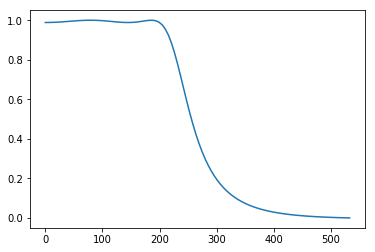

In [4]:
# we can also plot the magnitude response against true frequencies, focusing on the passband
wb, Hb = sp.freqz(b, a, 4096);
plt.plot(wb[0:100]/np.pi * (SF/2), np.abs(Hb[0:100]));

In [5]:
# let's filter the signal and hear the result
y = sp.lfilter(b, a, s)
IPython.display.Audio(data = y, rate = SF)

Well, it's certainly not a perfect source separation but, if you're trying to learn the bass part, this would be a good start. 

We can try to achieve the same effect using FIR filters, and you'll see it's possible but we will need a lot of taps since the bandwidth is small. We can use the built-in normalization facility of Scipy's `remez()` function:

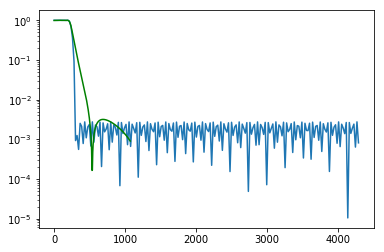

In [6]:
# transition band:
tb = 100
# length of the filter
M = 1200
h = sp.remez(M, [0, fc, fc+tb, SF/2], [1, 0], [1, 1], Hz=SF, maxiter=50)

w, H = sp.freqz(h, 1, 1024)
plt.semilogy(w[0:200]/np.pi * (SF/2), np.abs(H[0:200]))
plt.plot(wb[0:200]/np.pi * (SF/2), np.abs(Hb[0:200]), 'green');

As you can see, the FIR filter will be very expensive! Is it worth it? Well, you can judge for yourself: arguably linear phase preserves the instrumental attack more, but the high frequency rejection is not as good.

In [7]:
y = sp.lfilter(h, 1, s)
IPython.display.Audio(y, rate=SF)

Just like we tried to extract the bass, we can try to extract parts of the drum patterd. Usually, we get a good feel for the hi-hat and cymbals by keeping frequencies above 7KHz.

Let's use an FIR highpass; note that, to design a highpass, we choose a type II filter, so the length will be odd

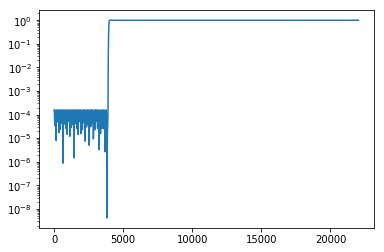

In [8]:
fh = 4000; 
M = 1601;
hh = sp.remez(M, [0, fh - tb, fh, SF/2], [0, 1], [10, 1], Hz=SF, maxiter=50)

w, HH = sp.freqz(hh, 1, 1024)
plt.semilogy(w/np.pi * (SF/2), np.abs(HH));

In [9]:
y = sp.lfilter(hh, [1], s);
IPython.display.Audio(data = y, rate = SF)